<a href="https://colab.research.google.com/github/jasonericr/dissertation/blob/main/dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Research Steps**
1. Load Data
2. Concantenate Financial Statement Data into 1 dateframe
3. Clean Data
<br/>
    a. Check/impute for missing values
    b.

#### LOAD NECESSARY LIBRARIES

In [1]:
# for working with Excel files
!pip install openpyxl

In [2]:
# for feature selection using reinforcement learning
!pip install FSRLearning

In [3]:
!pip install scikit-optimize

In [4]:
!pip install hyperopt

In [5]:
!pip install hpsklearn

In [6]:
!pip install shap

In [7]:
# Trend analysis
!pip install pymannkendall

In [8]:
!pip install ruptures
import ruptures as rpt

In [9]:
from statsmodels.tsa.stattools import acf
from itertools import product

In [10]:
# import needed libraries
from google.colab import files
import io
import json
import numpy as np
import pandas as pd
from datetime import date as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
from openpyxl import load_workbook
import FSRLearning
from FSRLearning import FeatureSelectorRL
#from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
# import Hyperopt for Bayesian Grid Search
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
#from statsmodels.tsa.seasonal import STL
import xgboost as xgb
import torch.nn as torch
import shap
# import mann kendall test for trend hypothesis testing
import pymannkendall as mk

#Update pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


#### DATA INGESTION

In [11]:
# financial statement data files to upload
uploaded = files.upload()

Saving aapl-financials.xlsx to aapl-financials.xlsx
Saving adp-financials.xlsx to adp-financials.xlsx
Saving apd-financials.xlsx to apd-financials.xlsx
Saving axp-financials.xlsx to axp-financials.xlsx
Saving bac-financials.xlsx to bac-financials.xlsx
Saving c-financials.xlsx to c-financials.xlsx
Saving clx-financials.xlsx to clx-financials.xlsx
Saving cop-financials.xlsx to cop-financials.xlsx
Saving cost-financials.xlsx to cost-financials.xlsx
Saving cvs-financials.xlsx to cvs-financials.xlsx
Saving cvx-financials.xlsx to cvx-financials.xlsx
Saving dell-financials.xlsx to dell-financials.xlsx
Saving d-financials.xlsx to d-financials.xlsx
Saving dis-financials.xlsx to dis-financials.xlsx
Saving dov-financials.xlsx to dov-financials.xlsx
Saving dow-financials.xlsx to dow-financials.xlsx
Saving duk-financials.xlsx to duk-financials.xlsx
Saving eco-financials.xlsx to eco-financials.xlsx
Saving emr-financials.xlsx to emr-financials.xlsx
Saving f-financials.xlsx to f-financials.xlsx
Saving

In [12]:
# create an empty dataframe
df = pd.DataFrame()

# loop through all fin statement excel files and load to df
for file in uploaded.keys():
  # create temp df to load each individual stock
  temp_df = pd.DataFrame()

  try:
    # upload file from google docs and transpose; upload by each FS type
    xlsx_file = io.BytesIO(uploaded.get(file))
    income_stmt = pd.read_excel(xlsx_file, 'Income-Quarterly', header=None)
    income_stmt_t = income_stmt.set_index([0]).T.reset_index()
    # need EPS diluted from TTM to calc share price; rename Quarterly EPS Diluted to avoid naming conflict
    income_stmt_t.rename(columns={'EPS (Diluted)': 'EPS (Diluted) Qrtly'}, inplace=True)

    # only pull in TTM EPS diluted to calc share price
    income_stmt_ttm = pd.read_excel(xlsx_file, 'Income-TTM',  header=None)
    income_stmt_ttm_t = income_stmt_ttm.set_index([0]).T.reset_index()
    income_stmt_ttm_t = income_stmt_ttm_t[['index', 'EPS (Diluted)']]
    income_stmt_ttm_t.rename(columns={'index':'index_v'}, inplace=True)

    bs_stmt = pd.read_excel(xlsx_file, 'Balance-Sheet-Quarterly', header=None)
    bs_stmt_t = bs_stmt.set_index([0]).T.reset_index()
    bs_stmt_t.rename(columns={'index':'index_x', 'Date':'date_x'}, inplace=True)

    cf_stmt = pd.read_excel(xlsx_file, 'Cash-Flow-Quarterly', header=None)
    cf_stmt_t = cf_stmt.set_index([0]).T.reset_index()
    cf_stmt_t.rename(columns={'index':'index_y', 'Date':'date_y'}, inplace=True)

    ratios_stmt = pd.read_excel(xlsx_file, 'Ratios-Quarterly', header=None)
    ratios_stmt_t = ratios_stmt.set_index([0]).T.reset_index()
    ratios_stmt_t.rename(columns={'index':'index_z', 'Date':'date_z'}, inplace=True)


    # concatenate all 4 different fin statements into temp df and add field for ticker symbol
    temp_df = pd.concat([income_stmt_t, income_stmt_ttm_t, bs_stmt_t, cf_stmt_t, ratios_stmt_t], axis=1)
    temp_df = temp_df.drop(columns=['index_v', 'index_x', 'index_y', 'index_z', 'date_x', 'date_y', 'date_z'])
    temp_df['ticker_symbol'] = file.replace('-financials.xlsx', '')


    if df.empty:
      df = temp_df
    else:
      df = pd.concat([df, temp_df], axis=0)

  except:
    continue

#### DATA CLEANUP

In [13]:
df.select_dtypes('object').head()

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,EPS (Diluted),Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol
0,2025-06-28,94036,0.09628,50318,43718,6650,8866,15516,0,28202,0,171,28031,4597,23434,0,23434,0.0926,14902.886,14948.179,-0.02606,1.57,1.57,0.12143,1.638,0.26,0.04,0.46491,0.29991,0.2492,0.25953,0.164,30861,0.32818,2830,28031,0.29809,6.59,36269,19103,132986,-0.13104,46835,5925,14359,122491,48508,77614,0,82882,209004,331495,50374,8979,19268,141120,62499,82430,124545,42115,265665,101698,0.00389,-17607,-6369,65830,31288,-0.39525,2.093098,-18629,4.417,23434,2830,3168,-1565,27867,-0.03434,-3462,0,8875,-340,5073,-3945,-21075,2711,-2524,-24833,8107,24405,-0.08619,0.25953,1.638,3003295.89208,-0.07009,2972007.89208,30.251,7.35,45.622,31.224485,27.663574,1.544858,0.724256,0.868,NaN,NaN,NaN,0.596086,0.005,0.166,0.026061,0.031061,aapl
1,2025-03-29,95359,0.05075,50492,44867,6728,8550,15278,0,29589,0,279,29310,4530,24780,0,24780,0.0484,14994.082,15056.133,-0.02642,1.65,1.65,0.07843,1.393,0.25,0.04167,0.47051,0.31029,0.25986,0.21897,0.15455,31971,0.33527,2661,29310,0.30736,6.42,28162,20336,132922,-0.1812,49798,6269,14109,118674,46876,84424,0,81259,212559,331233,54126,8976,19620,144571,61849,78566,119866,41300,264437,98186,-0.06123,-15552,-6363,66796,34736,-0.39848,2.3071,-25897,4.455,24780,2661,3226,-6715,23952,0.05562,-3071,0,6020,-32,2917,-3758,-25898,976,-326,-29006,-2137,20881,0.00904,0.21897,1.393,3273309.7067,0.23616,3238573.7067,33.643,8.176,49.005,33.236295,29.877959,1.469938,0.679915,0.821,NaN,NaN,NaN,0.591658,0.005,0.152,0.02642,0.03142,aapl
2,2024-12-28,124300,0.03951,66025,58275,7175,8268,15443,0,42832,0,248,42584,6254,36330,0,36330,0.07118,15081.724,15150.865,-0.02733,2.41,2.4,0.10092,1.79,0.25,0.04167,0.46883,0.34459,0.29228,0.21718,0.14686,45664,0.36737,3080,42584,0.34259,6.3,30299,23476,141368,-0.18083,59306,6911,13248,133240,46069,87593,0,77183,210845,344085,61910,8461,12843,144365,61151,83956,132962,49006,277327,96799,-0.10404,-11221,-6789,66758,44569,-0.30938,2.94168,-11125,4.426,36330,3080,3286,-12761,29935,-0.249

In [14]:
# change object features to numerical
obj_cls_list = list(df.select_dtypes('object').columns)[1:-1]
#for col in obj_cls_list:
#  df[col] = np.where(df[col]==None, np.nan, df[col])
for col in obj_cls_list:
  df[col] = df[col].astype('float')

#### FEATURE ENGINEERING

In [15]:
df.head()

,index,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,EPS (Diluted),Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol
0,1.0,2025-06-28,94036.0,0.09628,50318.0,43718.0,6650.0,8866.0,15516.0,0.0,28202.0,0.0,171.0,28031.0,4597.0,23434.0,0.0,23434.0,0.09260,14902.886,14948.179,-0.02606,1.57,1.57,0.12143,1.638,0.26,0.04000,0.46491,0.29991,0.24920,0.25953,0.16400,30861.0,0.32818,2830.0,28031.0,0.29809,6.59,36269.0,19103.0,132986.0,-0.13104,46835.0,5925.0,14359.0,122491.0,48508.0,77614.0,0.0,82882.0,209004.0,331495.0,50374.0,8979.0,19268.0,141120.0,62499.0,82430.0,124545.0,42115.0,265665.0,101698.0,0.00389,-17607.0,-6369.0,65830.0,31288.0,-0.39525,2.093098,-18629.0,4.417,23434.0,2830.0,3168.0,-1565.0,27867.0,-0.03434,-3462.0,0.0,8875.0,-340.0,5073.0,-3945.0,-21075.0,2711.0,-2524.0,-24833.0,8107.0,24405.0,-0.08619,0.25953,1.638,3.003296e+06,-0.07009,2.972008e+06,30.251,7.350,45.622,31.224485,27.663574,1.544858,0.724256,0.868,NaN,NaN,NaN,0.596086,0.005,0.166,0.026061,0.031061,aapl
1,2.0,2025-03-29,95359.0,0.05075,50492.0,44867.0,6728.0,8550.0,15278.0,0.0,29589.0,0.0,279.0,29310.0,4530.0,24780.0,0.0,24780.0,0.04840,14994.082,15056.133,-0.02642,1.65,1.65,0.07843,1.393,0.25,0.04167,0.47051,0.31029,0.25986,0.21897,0.15455,31971.0,0.33527,2661.0,29310.0,0.30736,6.42,28162.0,20336.0,132922.0,-0.18120,49798.0,6269.0,14109.0,118674.0,46876.0,84424.0,0.0,81259.0,212559.0,331233.0,54126.0,8976.0,19620.0,144571.0,61849.0,78566.0,119866.0,41300.0,264437.0,98186.0,-0.06123,-15552.0,-6363.0,66796.0,34736.0,-0.39848,2.307100,-25897.0,4.455,24780.0,2661.0,3226.0,-6715.0,23952.0,0.05562,-3071.0,0.0,6020.0,-32.0,2917.0,-3758.0,-25898.0,976.0,-326.0,-29006.0,-2137.0,20881.0,0.00904,0.21897,1.393,3.273310e+06,0.23616,3.238574e+06,33.643,8.176,49.005,33.236295,29.877959,1.469938,0.679915,0.821,NaN,NaN,NaN,0.591658,0.005,0.152,0.026420,0.031420,aapl
2,3.0,2024-12-28,124300.0,0.03951,66025.0,58275.0,7175.0,8268.0,15443.0,0.0,42832.0,0.0,248.0,42584.0,6254.0,36330.0,0.0,36330.0,0.07118,15081.724,15150.865,-0.02733,2.41,2.40,0.10092,1.790,0.25,0.04167,0.46883,0.

In [16]:
# Create
df_copy = df.copy()

# calculate stock price at each time interval from EPS and PE Ratio
df_copy['share_price'] = df_copy['EPS (Diluted)'] * df_copy['PE Ratio']
df_copy['share_price'] = df_copy['share_price'].apply(lambda x: np.round(x, 2))

# remove records where there is no share price
df_no_null_stock_price = df_copy[~df_copy['share_price'].isnull()]

# number of records before and after removing dataframes with null price values
display(print(f'% of records removed as they have null share prices: {(df_copy.shape[0]-df_no_null_stock_price.shape[0])/df_copy.shape[0]*100:0.1f}%'))

# can drop TTM EPS Diluted as share price has been calculated; the Quarterly EPS Diluted field will remain
df_no_null_stock_price = df_no_null_stock_price.drop(columns=['EPS (Diluted)'])

# Calculate price percentage change
# Sort by ticker symbol and date
df_no_null_stock_price = df_no_null_stock_price.sort_values(['ticker_symbol', 'Date'], ascending=[True, True])
# Group by stock symbol and remove rows with no share price
df_no_null_stock_price = df_no_null_stock_price[df_no_null_stock_price['share_price']!=0]

# change Data to date data type
df_no_null_stock_price['Date'] = pd.to_datetime(df_no_null_stock_price['Date'])
# limit stocks to those with financial data betwee 1996 and 2024
df_no_null_stock_price = df_no_null_stock_price[(df_no_null_stock_price['Date']>'1995-12-31') & (df_no_null_stock_price['Date']<'2025-01-01')]

# calculate stock price % change period over period for each ticker symbol
df_no_null_stock_price['share_prct_chg'] = df_no_null_stock_price.groupby(['ticker_symbol'], as_index=False)['share_price'].pct_change()
# remove any records with no stock share % change; these would be the first period of data for each stock
df_no_null_stock_chng = df_no_null_stock_price[~df_no_null_stock_price['share_prct_chg'].isnull()]

# reset index for each stock ticker based on reporting date
# drop original index field
df_no_null_stock_chng = df_no_null_stock_chng.drop(columns=['index'])
# sort df by ticker symbol and date
df_no_null_stock_chng = df_no_null_stock_chng.sort_values(['ticker_symbol', 'Date'], ascending=[True, True])
# reset index based on reporting date grouped by ticker symbol
df_no_null_stock_chng['index'] = df_no_null_stock_chng.groupby(['ticker_symbol'], as_index=False).cumcount()+1
# calc % record loss after
display(print(f'% record loss after dropping stocks with null % change in share price: {(df_no_null_stock_price.shape[0]-df_no_null_stock_chng.shape[0])/df_no_null_stock_price.shape[0]*100:0.1f}%'))
df_no_null_stock_chng.head(10)

% of records removed as they have null share prices: 8.8%


None

% record loss after dropping stocks with null % change in share price: 1.0%


None

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol,share_price,share_prct_chg,index
116,1996-06-28,2179.0,-0.15379,1776.0,403.0,364.0,155.0,519.0,0.0,-116.0,0.0,-65.0,-51.0,-19.0,-32.0,0.0,-32.0,NaN,13858.320,13858.320,0.00432,-0.002,-0.002,NaN,0.020,0.0,NaN,0.18495,-0.05324,-0.01469,0.12575,NaN,-29.0,-0.01331,22.0,-51.0,-0.02341,1359.0,0.0,1359.0,-0.18914,1292.0,1061.0,742.0,4454.0,615.0,0.0,0.0,276.0,891.0,5345.0,762.0,0.0,187.0,1926.0,977.0,949.0,1399.0,450.0,3325.0,1136.0,0.60226,1609.0,-12.0,2020.0,223.0,-0.76939,0.016091,2528.0,0.146,-32.0,22.0,0.0,297.0,287.0,NaN,-13.0,0.0,92.0,9.0,88.0,0.0,3.0,481.0,NaN,484.0,859.0,274.0,NaN,0.12575,0.020,2598.053010,-0.53837,2375.053010,-3.327,0.247,1.286,-3.906847,-4.631111,0.562376,1.376428,2.313,NaN,NaN,NaN,-0.434577,0.011,0.0,-0.004318,0.006682,aapl,0.19,-0.136364,1
115,1996-09-27,2321.0,-0.22711,1810.0,511.0,359.0,146.0,477.0,-28.0,34.0,0.0,-6.0,40.0,15.0,25.0,0.0,25.0,-0.58333,13949.264,13949.264,-0.00156,0.002,0.002,-0.5,0.024,0.0,NaN,0.22016,0.01465,0.01077,0.14261,0.37500,46.0,0.01982,6.0,40.0,0.01723,1552.0,193.0,1745.0,0.83298,1496.0,662.0,612.0,4515.0,598.0,0.0,0.0,251.0,849.0,5364.0,791.0,0.0,186.0,2003.0,1026.0,949.0,1303.0,354.0,3306.0,1135.0,0.48560,1634.0,0.0,2058.0,610.0,2.24468,0.043730,2512.0,0.148,25.0,6.0,0.0,265.0,296.0,NaN,35.0,0.0,-193.0,42.0,-116.0,0.0,14.0,-1.0,NaN,13.0,193.0,331.0,NaN,0.14261,0.024,2777.856761,-0.39202,2167.856761,-3.404,0.283,1.350,7.159425,6.808472,0.551506,1.618073,2.254,NaN,NaN,NaN,-0.437128,0.005,0.0,0.001563,0.006563,aapl,0.20,0.052632,2
114,1996-12-27,2129.0,-0.32370,1732.0,397.0,372.0,149.0,521.0,0.0,-124.0,0.0,-4.0,-120.0,0.0,-120.0,0.0,-120.0,NaN,13947.584,13947.584,0.01250,-0.009,-0.009,NaN,0.005,0.0,NaN,0.18647,-0.05824,-0.05636,0.03476,NaN,-95.0,-0.04462,25.0,-120.0,-0.05636,1174.0,633.0,1807.0,0.64273,1492.0,488.0,632.0,4419.0,593.0,0.0,0.0,260.0,853.0,5272.0,820.0,0.0,180.0,2044.0,1044.0,950.0,1286.0,336.0,3330.0,1130.0,0.40898,1514.0,0.0,1942.0,677.0,1.27181,0.048539,2375.0,0.139,

In [17]:
df_no_null_stock_chng[df_no_null_stock_chng['ticker_symbol']=='aapl']['index'].min()

1

In [18]:
df_no_null_stock_chng[(df_no_null_stock_chng['ticker_symbol']=='msft') & (df_no_null_stock_chng['index']==1)]

,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol,share_price,share_prct_chg,index
116,1996-06-30,2255.0,0.39112,241.0,2014.0,751.0,453.0,1223.0,19.0,791.0,0.0,-69.0,860.0,301.0,559.0,0.0,559.0,0.51902,10320.0,10320.0,0.01415,0.073,0.055,0.52778,0.073,0.0,NaN,0.89313,0.35078,0.24789,0.33481,0.35,1004.0,0.44523,144.0,860.0,0.38137,6940.0,0.0,6940.0,0.46105,639.0,0.0,260.0,7839.0,1326.0,675.0,0.0,253.0,2254.0,10093.0,808.0,560.0,0.0,2425.0,1057.0,0.0,760.0,760.0,3185.0,0.0,NaN,3984.0,0.0,6908.0,6940.0,0.46105,0.672481,5414.0,0.669,559.0,144.0,0.0,210.0,913.0,0.7832,-158.0,0.0,-874.0,NaN,-1032.0,0.0,-465.0,0.0,233.0,-232.0,-351.0,755.0,1.61246,0.33481,0.073,71861.701231,0.35782,64921.701231,32.739,8.288,10.403,22.282698,19.322856,NaN,3.125361,3.233,NaN,NaN,NaN,0.287278,0.0,0.0,-0.014151,-0.014151,msft,7.04,0.175292,1


#### EDA

In [19]:
# Ticker symbols and their amount of missing share prices
# no rows should be missing share prices
df_no_null_stock_chng.groupby(['ticker_symbol']).agg(null_vals=('share_price', lambda x:x.isnull().sum()))

,null_vals
ticker_symbol,
aapl,0
adp,0
apd,0
axp,0
bac,0
c,0
clx,0
cop,0
cost,0


##### Check NULL values for Predictor Features

In [20]:
# check % missing values by feature
(df_no_null_stock_chng.isnull().sum()/df_no_null_stock_chng.shape[0]*100).sort_values(ascending=False)

,0
0,
Return on Equity (ROE),100.000000
Asset Turnover,100.000000
Return on Assets (ROA),100.000000
Net Cash (Debt) Growth,86.077539
Free Cash Flow Growth,29.555800
Dividend Growth,25.694553
Net Cash Per Share,24.705698
Shares Outstanding (Diluted),24.674305
Other Investing Activities,22.414064


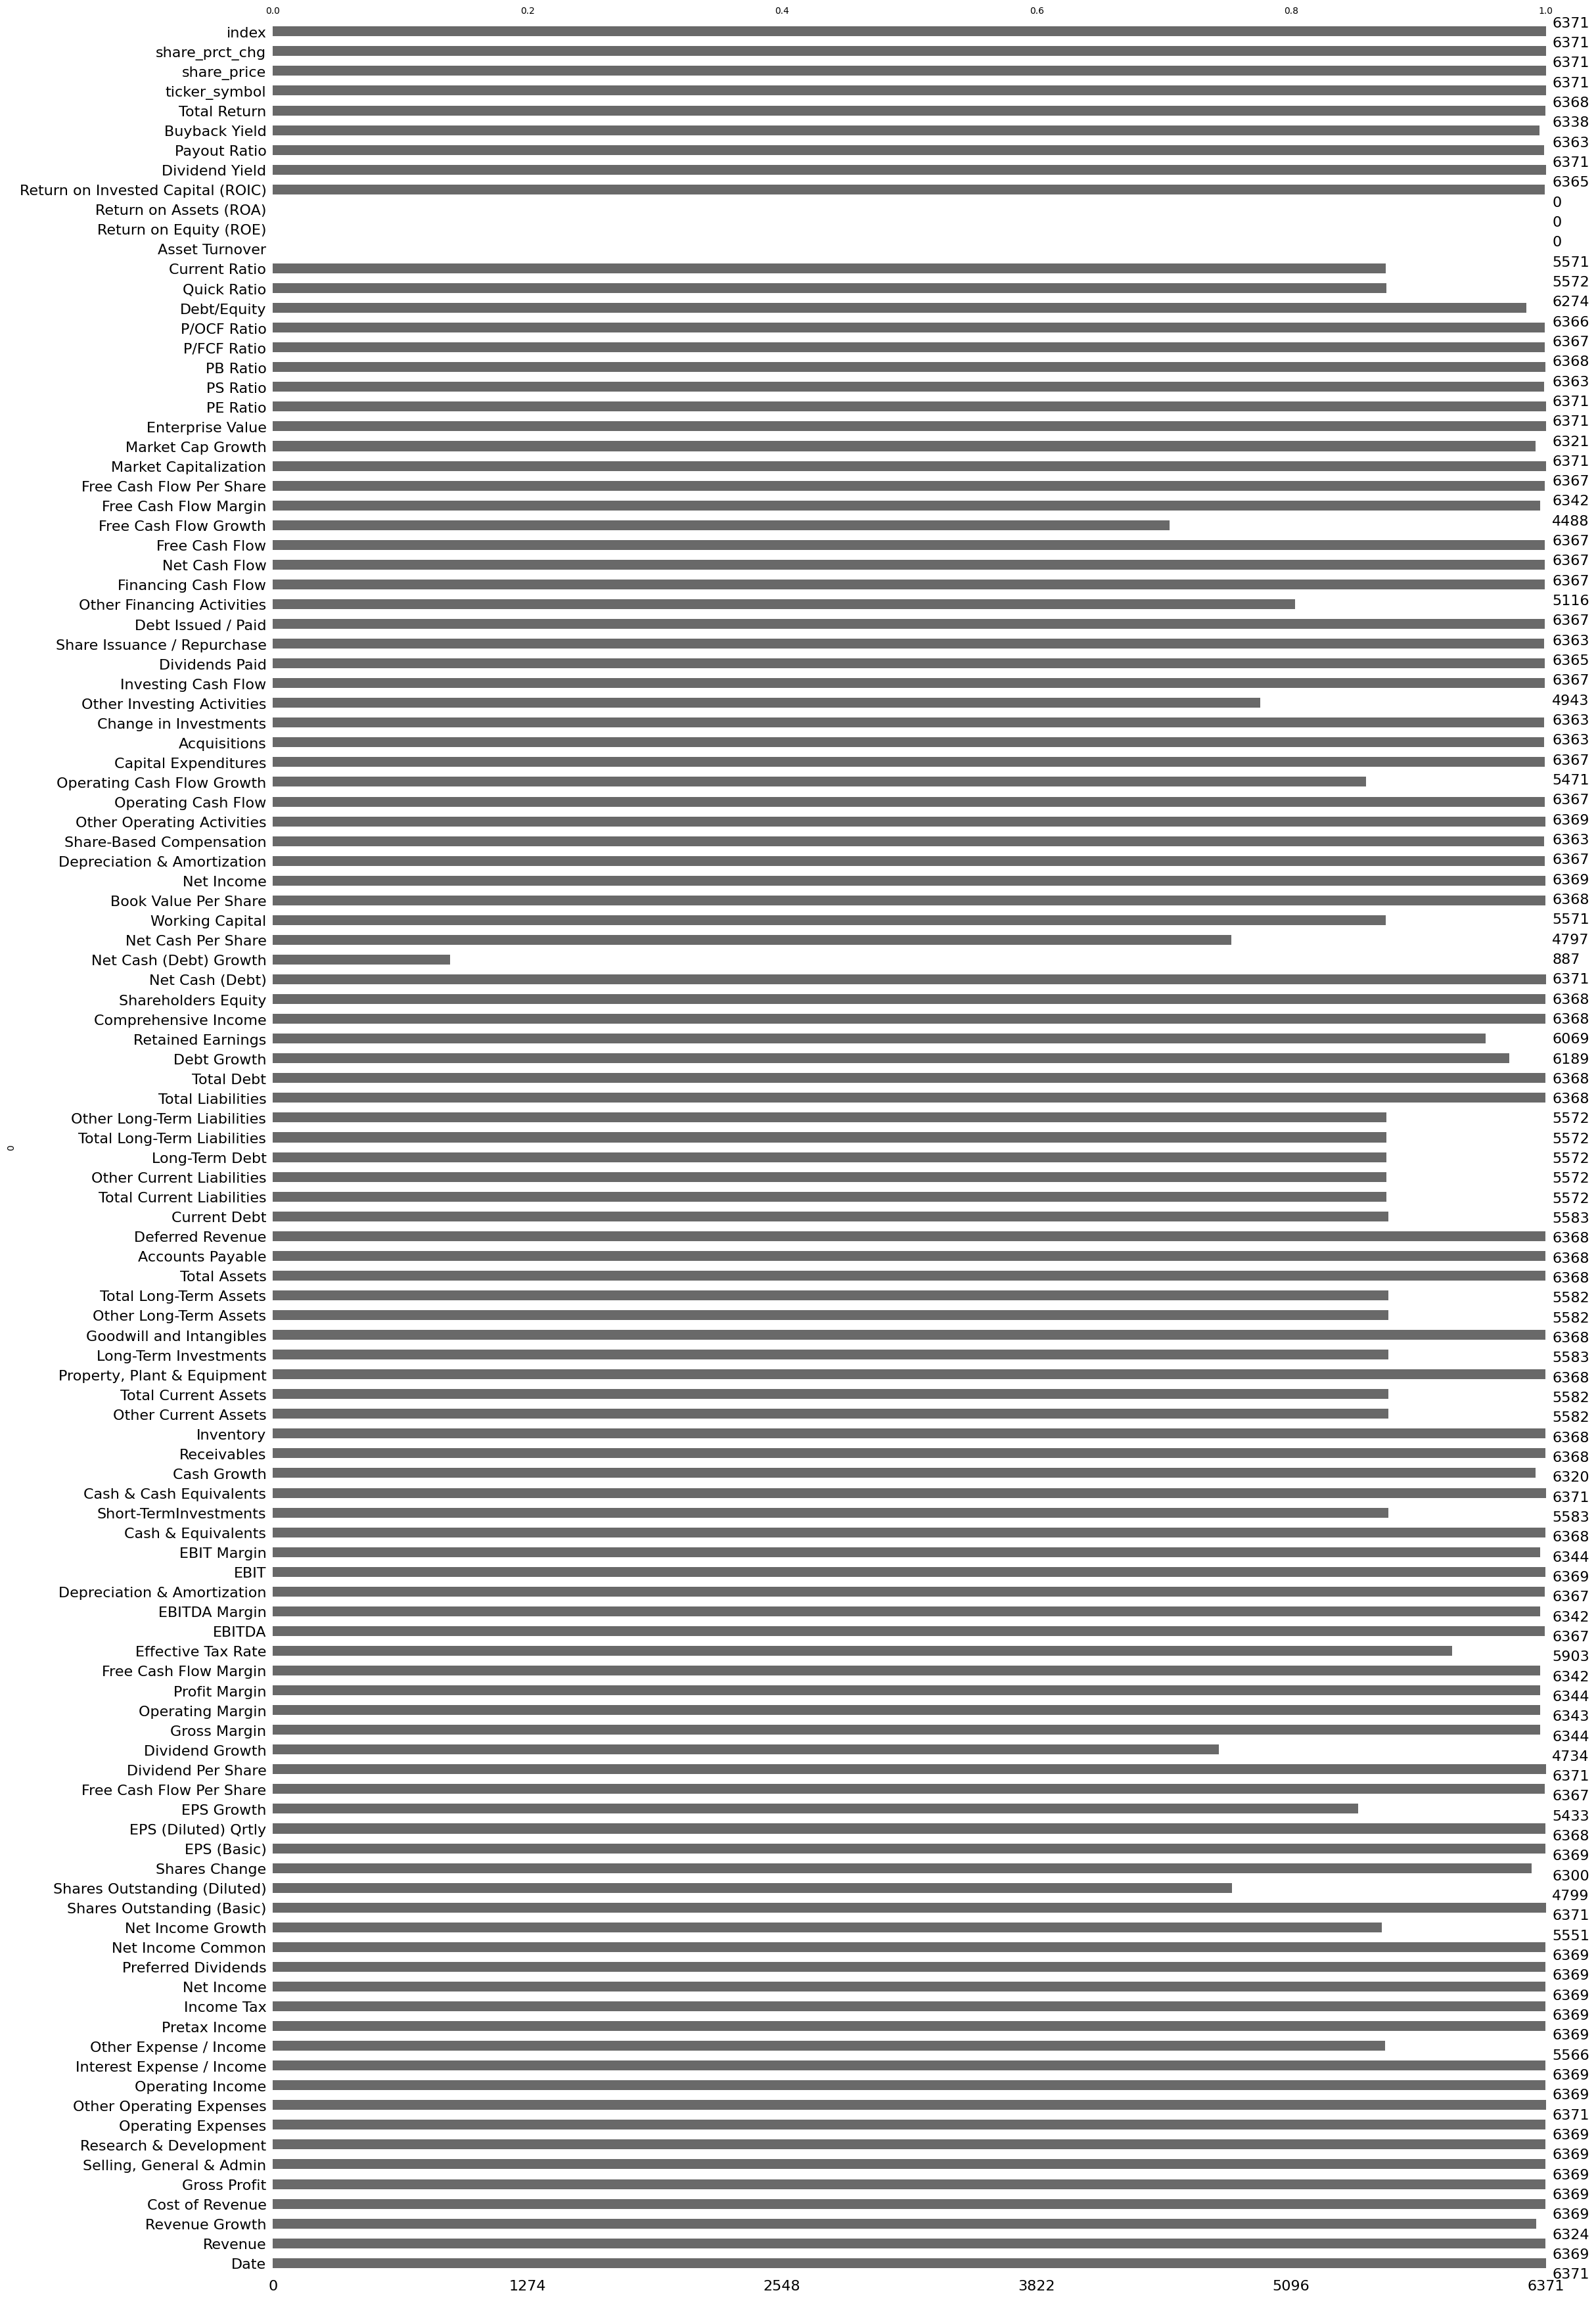

In [21]:
# Visualize missing values
# missing feature variables values are purposeful as they represent true absences of values
msno.bar(df_no_null_stock_chng)
plt.show()

In [22]:
# Replace missing share prices with feed-forward price (price from previous period reported)
df_sorted = df_no_null_stock_chng.sort_values(by=['ticker_symbol', 'index'], ascending=[True, True])

In [23]:
# Verify that the share price field (target variable) has no NULL values
assert df_sorted[df_sorted['share_price'].isnull()].shape[0] == 0, 'Not all share prices values are zero. Check the forward-fill.'

In [24]:
# 5-point stats for each feature
df_sorted.describe()


,Date,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,EBIT,EBIT Margin,Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,share_price,share_prct_chg,index
count,6371,6369.000000,6324.000000,6369.000000,6369.000000,6369.000000,6369.000000,6369.000000,6371.000000,6369.000000,6369.000000,5566.000000,6369.000000,6369.000000,6369.000000,6369.000000,6369.000000,5551.000000,6371.000000,4799.000000,6300.000000,6369.000000,6368.000000,5433.000000,6367.000000,6371.000000,4734.000000,6344.000000,6343.000000,6344.000000,6342.000000,5903.000000,6367.000000,6342.000000,6367.000000,6369.000000,6344.000000,6368.000000,5583.000000,6371.000000,6320.000000,6368.000000,6368.000000,5582.000000,5582.000000,6368.000000,5583.000000,6368.000000,5582.000000,5582.000000,6.368000e+03,6368.000000,6368.000000,5583.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,6.368000e+03,6368.000000,6189.000000,6069.000000,6368.000000,6368.000000,6371.000000,887.000000,4797.000000,5571.00000,6368.000000,6369.000000,6367.000000,6363.000000,6369.000000,6367.000000,5471.000000,6367.000000,6363.000000,6363.000000,4943.000000,6367.000000,6365.000000,6363.000000,6367.000000,5116.000000,6367.000000,6367.000000,6367.000000,4488.000000,6342.000000,6367.000000,6.371000e+03,6321.000000,6.371000e+03,6371.000000,6363.000000,6368.000000,6367.000000,6366.000000,6274.000000,5572.000000,5571.000000,0.0,0.0,0.0,6365.000000,6371.000000,6363.000000,6338.000000,6368.000000,6371.000000,6371.000000,6371.000000
mean,2011-06-09 23:32:25.503060736,14316.398798,0.179239,8742.488819,5573.909979,2652.304494,280.732286,3578.652601,645.413148,1995.257378,153.108428,-41.196085,1878.151056,504.610789,1373.540267,8.751508,1364.793924,0.512023,2176.967047,2497.199001,0.011669,0.874783,0.863799,0.477560,0.820492,0.410126,0.177511,0.483000,0.163914,0.136680,0.199910,0.269222,2731.310169,0.261090,700.779519,2031.259484,0.197890,13797.445005,3335.170561,17843.463983,0.338192,8031.716260,3656.689847,2435.496610,19025.655764,21414.729632,6659.390216,15511.264442,4531.249115,50170.849431,1.521728e+05,9741.586067,1056.928687,3038.98

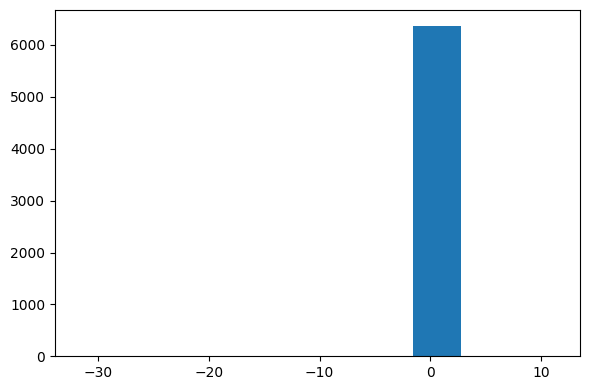

In [25]:
# Distributions
plt.figure(figsize=(6,4))
plt.hist(x=df_sorted['share_prct_chg'], histtype='stepfilled')
plt.tight_layout()
plt.show()

#### ADDITIONAL FEATURE ENGINEERING

In [26]:

# add field designating whether report date is prior to Robinhood launch (4/2013)
#df_sorted['after_rbhd'] = np.where(df_sorted['Date']>='2013-04-01', 1, 0)

# # remove Date field as no longer needed given Index provides chronological variable
df_no_date = df_sorted.drop(columns=['Date'])

# # Drop columns with no data
no_missing_data_mask = ((df_no_date.isnull().sum()/df_no_date.shape[0]) != 100.00)

# # Remove fields missing all data
df_filtered = df_no_date[list(df_no_date.columns[no_missing_data_mask])]
df_filtered.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,"Selling, General & Admin",Research & Development,Operating Expenses,Other Operating Expenses,Operating Income,Interest Expense / Income,Other Expense / Income,Pretax Income,Income Tax,Net Income,Net Income,Preferred Dividends,Net Income Common,Net Income Growth,Shares Outstanding (Basic),Shares Outstanding (Diluted),Shares Change,EPS (Basic),EPS (Diluted) Qrtly,EPS Growth,Free Cash Flow Per Share,Free Cash Flow Per Share,Dividend Per Share,Dividend Growth,Gross Margin,Operating Margin,Profit Margin,Free Cash Flow Margin,Free Cash Flow Margin,Effective Tax Rate,EBITDA,EBITDA Margin,Depreciation & Amortization,Depreciation & Amortization,EBIT,EBIT Margin,Cash & Equivalents,Short-TermInvestments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,Goodwill and Intangibles,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Accounts Payable,Deferred Revenue,Current Debt,Total Current Liabilities,Other Current Liabilities,Long-Term Debt,Total Long-Term Liabilities,Other Long-Term Liabilities,Total Liabilities,Total Debt,Debt Growth,Retained Earnings,Comprehensive Income,Shareholders Equity,Net Cash (Debt),Net Cash (Debt) Growth,Net Cash Per Share,Working Capital,Book Value Per Share,Net Income,Net Income,Depreciation & Amortization,Depreciation & Amortization,Share-Based Compensation,Other Operating Activities,Operating Cash Flow,Operating Cash Flow Growth,Capital Expenditures,Acquisitions,Change in Investments,Other Investing Activities,Investing Cash Flow,Dividends Paid,Share Issuance / Repurchase,Debt Issued / Paid,Other Financing Activities,Financing Cash Flow,Net Cash Flow,Free Cash Flow,Free Cash Flow Growth,Free Cash Flow Margin,Free Cash Flow Margin,Free Cash Flow Per Share,Free Cash Flow Per Share,Market Capitalization,Market Cap Growth,Enterprise Value,PE Ratio,PS Ratio,PB Ratio,P/FCF Ratio,P/OCF Ratio,Debt/Equity,Quick Ratio,Current Ratio,Asset Turnover,Return on Equity (ROE),Return on Assets (ROA),Return on Invested Capital (ROIC),Dividend Yield,Payout Ratio,Buyback Yield,Total Return,ticker_symbol,share_price,share_prct_chg,index
116,2179.0,-0.15379,1776.0,403.0,364.0,155.0,519.0,0.0,-116.0,0.0,-65.0,-51.0,-19.0,-32.0,-32.0,0.0,-32.0,NaN,13858.320,13858.320,0.00432,-0.002,-0.002,NaN,0.020,0.020,0.0,NaN,0.18495,-0.05324,-0.01469,0.12575,0.12575,NaN,-29.0,-0.01331,22.0,22.0,-51.0,-0.02341,1359.0,0.0,1359.0,-0.18914,1292.0,1061.0,742.0,4454.0,615.0,0.0,0.0,276.0,891.0,5345.0,762.0,0.0,187.0,1926.0,977.0,949.0,1399.0,450.0,3325.0,1136.0,0.60226,1609.0,-12.0,2020.0,223.0,-0.76939,0.016091,2528.0,0.146,-32.0,-32.0,22.0,22.0,0.0,297.0,287.0,NaN,-13.0,0.0,92.0,9.0,88.0,0.0,3.0,481.0,NaN,484.0,859.0,274.0,NaN,0.12575,0.12575,0.020,0.020,2598.053010,-0.53837,2375.053010,-3.327,0.247,1.286,-3.906847,-4.631111,0.562376,1.376428,2.313,NaN,NaN,NaN,-0.434577,0.011,0.0,-0.004318,0.006682,aapl,0.19,-0.136364,1
115,2321.0,-0.22711,1810.0,511.0,359.0,146.0,477.0,-28.0,34.0,0.0,-6.0,40.0,15.0,25.0,25.0,0.0,25.0,-0.58333,13949.264,13949.264,-0.00156,0.002,0.002,-0.5,0.024,0.024,0.0,NaN,0.22016,0.01465,0.01077,0.14261,0.14261,0.375,46.0,0.01982,6.0,6.0,40.0,0.01723,1552.0,193.0,1745.0,0.83298,1496.0,662.0,612.0,4515.0,598.0,0.0,0.0,251.0,849.0,5364.0,791.0,0.0,186.0,2003.0,1026.0,949.0,1303.0,354.0,3306.0,1135.0,0.48560,1634.0,0.0,2058.0,610.0,2.24468,0.043730,2512.0,0.148,25.0,25.0,6.0,6.0,0.0,265.0,296.0,NaN,35.0,0.0,-193.0,42.0,-116.0,0.0,14.0,-1.0,NaN,13.0,193.0,331.0,NaN,0.14261,0.14261,0.024,0.024,2777.856761,-0.39202,2167.856761,-3.404,0.283,1.350,7.159425,6.808472,0.551506,1.618073,2.254,NaN,NaN,NaN,-0.437128,0.005,0.0,0.001563,0.006563,aapl,0.20,0.052632,2
114,2129.0,-0.32370,1732.0,397.0,372.0,149.0,521.0,0.0,-124.0,0.0,-4.0,-120.0,0.0,-120.0,-120.0,0.0,-120.0,NaN,13947.584,13947.584,0.01250,-0.009,-0.009,NaN,0.005,0.005,0.0,NaN,0.18647,-0.05824,-0.05636,0.03476,0.03476,NaN

In [27]:
# clean/format column headers
df_filtered.columns = [col.lower() for col in df_filtered.columns]
df_filtered.columns = [col.replace(" ", "_") for col in df_filtered.columns]
df_filtered.columns = [col.replace(",", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("&", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("(", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace(")", "") for col in df_filtered.columns]
df_filtered.columns = [col.replace("/", "") for col in df_filtered.columns]

df_filtered_copy = df_filtered.loc[:,~df_filtered.columns.duplicated()].copy()
df_filtered_copy.head()

,revenue,revenue_growth,cost_of_revenue,gross_profit,selling_general__admin,research__development,operating_expenses,other_operating_expenses,operating_income,interest_expense__income,other_expense__income,pretax_income,income_tax,net_income,preferred_dividends,net_income_common,net_income_growth,shares_outstanding_basic,shares_outstanding_diluted,shares_change,eps_basic,eps_diluted_qrtly,eps_growth,free_cash_flow_per_share,dividend_per_share,dividend_growth,gross_margin,operating_margin,profit_margin,free_cash_flow_margin,effective_tax_rate,ebitda,ebitda_margin,depreciation__amortization,ebit,ebit_margin,cash__equivalents,short-terminvestments,cash__cash_equivalents,cash_growth,receivables,inventory,other_current_assets,total_current_assets,property_plant__equipment,long-term_investments,goodwill_and_intangibles,other_long-term_assets,total_long-term_assets,total_assets,accounts_payable,deferred_revenue,current_debt,total_current_liabilities,other_current_liabilities,long-term_debt,total_long-term_liabilities,other_long-term_liabilities,total_liabilities,total_debt,debt_growth,retained_earnings,comprehensive_income,shareholders_equity,net_cash_debt,net_cash_debt_growth,net_cash_per_share,working_capital,book_value_per_share,share-based_compensation,other_operating_activities,operating_cash_flow,operating_cash_flow_growth,capital_expenditures,acquisitions,change_in_investments,other_investing_activities,investing_cash_flow,dividends_paid,share_issuance__repurchase,debt_issued__paid,other_financing_activities,financing_cash_flow,net_cash_flow,free_cash_flow,free_cash_flow_growth,market_capitalization,market_cap_growth,enterprise_value,pe_ratio,ps_ratio,pb_ratio,pfcf_ratio,pocf_ratio,debtequity,quick_ratio,current_ratio,asset_turnover,return_on_equity_roe,return_on_assets_roa,return_on_invested_capital_roic,dividend_yield,payout_ratio,buyback_yield,total_return,ticker_symbol,share_price,share_prct_chg,index
116,2179.0,-0.15379,1776.0,403.0,364.0,155.0,519.0,0.0,-116.0,0.0,-65.0,-51.0,-19.0,-32.0,0.0,-32.0,NaN,13858.320,13858.320,0.00432,-0.002,-0.002,NaN,0.020,0.0,NaN,0.18495,-0.05324,-0.01469,0.12575,NaN,-29.0,-0.01331,22.0,-51.0,-0.02341,1359.0,0.0,1359.0,-0.18914,1292.0,1061.0,742.0,4454.0,615.0,0.0,0.0,276.0,891.0,5345.0,762.0,0.0,187.0,1926.0,977.0,949.0,1399.0,450.0,3325.0,1136.0,0.60226,1609.0,-12.0,2020.0,223.0,-0.76939,0.016091,2528.0,0.146,0.0,297.0,287.0,NaN,-13.0,0.0,92.0,9.0,88.0,0.0,3.0,481.0,NaN,484.0,859.0,274.0,NaN,2598.053010,-0.53837,2375.053010,-3.327,0.247,1.286,-3.906847,-4.631111,0.562376,1.376428,2.313,NaN,NaN,NaN,-0.434577,0.011,0.0,-0.004318,0.006682,aapl,0.19,-0.136364,1
115,2321.0,-0.22711,1810.0,511.0,359.0,146.0,477.0,-28.0,34.0,0.0,-6.0,40.0,15.0,25.0,0.0,25.0,-0.58333,13949.264,13949.264,-0.00156,0.002,0.002,-0.5,0.024,0.0,NaN,0.22016,0.01465,0.01077,0.14261,0.375,46.0,0.01982,6.0,40.0,0.01723,1552.0,193.0,1745.0,0.83298,1496.0,662.0,612.0,4515.0,598.0,0.0,0.0,251.0,849.0,5364.0,791.0,0.0,186.0,2003.0,1026.0,949.0,1303.0,354.0,3306.0,1135.0,0.48560,1634.0,0.0,2058.0,610.0,2.24468,0.043730,2512.0,0.148,0.0,265.0,296.0,NaN,35.0,0.0,-193.0,42.0,-116.0,0.0,14.0,-1.0,NaN,13.0,193.0,331.0,NaN,2777.856761,-0.39202,2167.856761,-3.404,0.283,1.350,7.159425,6.808472,0.551506,1.618073,2.254,NaN,NaN,NaN,-0.437128,0.005,0.0,0.001563,0.006563,aapl,0.20,0.052632,2
114,2129.0,-0.32370,1732.0,397.0,372.0,149.0,521.0,0.0,-124.0,0.0,-4.0,-120.0,0.0,-120.0,0.0,-120.0,NaN,13947.584,13947.584,0.01250,-0.009,-0.009,NaN,0.005,0.0,NaN,0.18647,-0.05824,-0.05636,0.03476,NaN,-95.0,-0.04462,25.0,-120.0,-0.05636,1174.0,633.0,1807.0,0.64273,1492.0,488.0,632.0,4419.0,593.0,0.0,0.0,260.0,853.0,5272.0,820.0,0.0,180.0,2044.0,1044.0,950.0,1286.0,336.0,3330.0,1130.0,0.40898,1514.0,0.0,1942.0,677.0,1.27181,0.048539,2375.0,0.139,0.0,187.0,92.0,-0.50802,-18.0,0.0,-440.0,-10.0,-468.0,0.0,3.0,-5.0,NaN,-2.0,-378.0,74.0,-0.52564,2880.650474,-0.26514,2203.650474,-3.323,0.327,1.483,9.413890,9.203356,0.581874,1.613992,2.162,NaN,NaN,NaN,-0.45597

In [28]:
df_filtered_copy.groupby(['index']).agg(total_periods=('index', np.size)).reset_index()

,index,total_periods
0,1,63
1,2,63
2,3,63
3,4,63
4,5,62
5,6,62
6,7,62
7,8,62
8,9,62
9,10,61


In [29]:
# count of time periods for each stock
df_filtered_copy.groupby(['ticker_symbol']).agg(total_periods=('index', np.size)).reset_index()

,ticker_symbol,total_periods
0,aapl,114
1,adp,110
2,apd,115
3,axp,115
4,bac,112
5,c,110
6,clx,108
7,cop,109
8,cost,115
9,cvs,109


In [30]:
# split predictor features and target variables into separate dataframes
X = df_filtered_copy.iloc[:, 1:-3]
y = df_filtered_copy.loc[:, 'share_prct_chg']

# change data types
X = X.apply(pd.to_numeric, errors='coerce')
y = y.astype('float')

#### TRAING MODEL WITH ALL FEATURES

In [31]:
df_filtered_copy.index.value_counts()

,count
5,63
4,63
3,63
6,62
10,62
7,62
9,62
8,62
15,61
11,61


In [32]:
df_filtered_copy.head(2)

,revenue,revenue_growth,cost_of_revenue,gross_profit,selling_general__admin,research__development,operating_expenses,other_operating_expenses,operating_income,interest_expense__income,other_expense__income,pretax_income,income_tax,net_income,preferred_dividends,net_income_common,net_income_growth,shares_outstanding_basic,shares_outstanding_diluted,shares_change,eps_basic,eps_diluted_qrtly,eps_growth,free_cash_flow_per_share,dividend_per_share,dividend_growth,gross_margin,operating_margin,profit_margin,free_cash_flow_margin,effective_tax_rate,ebitda,ebitda_margin,depreciation__amortization,ebit,ebit_margin,cash__equivalents,short-terminvestments,cash__cash_equivalents,cash_growth,receivables,inventory,other_current_assets,total_current_assets,property_plant__equipment,long-term_investments,goodwill_and_intangibles,other_long-term_assets,total_long-term_assets,total_assets,accounts_payable,deferred_revenue,current_debt,total_current_liabilities,other_current_liabilities,long-term_debt,total_long-term_liabilities,other_long-term_liabilities,total_liabilities,total_debt,debt_growth,retained_earnings,comprehensive_income,shareholders_equity,net_cash_debt,net_cash_debt_growth,net_cash_per_share,working_capital,book_value_per_share,share-based_compensation,other_operating_activities,operating_cash_flow,operating_cash_flow_growth,capital_expenditures,acquisitions,change_in_investments,other_investing_activities,investing_cash_flow,dividends_paid,share_issuance__repurchase,debt_issued__paid,other_financing_activities,financing_cash_flow,net_cash_flow,free_cash_flow,free_cash_flow_growth,market_capitalization,market_cap_growth,enterprise_value,pe_ratio,ps_ratio,pb_ratio,pfcf_ratio,pocf_ratio,debtequity,quick_ratio,current_ratio,asset_turnover,return_on_equity_roe,return_on_assets_roa,return_on_invested_capital_roic,dividend_yield,payout_ratio,buyback_yield,total_return,ticker_symbol,share_price,share_prct_chg,index
116,2179.0,-0.15379,1776.0,403.0,364.0,155.0,519.0,0.0,-116.0,0.0,-65.0,-51.0,-19.0,-32.0,0.0,-32.0,NaN,13858.320,13858.320,0.00432,-0.002,-0.002,NaN,0.020,0.0,NaN,0.18495,-0.05324,-0.01469,0.12575,NaN,-29.0,-0.01331,22.0,-51.0,-0.02341,1359.0,0.0,1359.0,-0.18914,1292.0,1061.0,742.0,4454.0,615.0,0.0,0.0,276.0,891.0,5345.0,762.0,0.0,187.0,1926.0,977.0,949.0,1399.0,450.0,3325.0,1136.0,0.60226,1609.0,-12.0,2020.0,223.0,-0.76939,0.016091,2528.0,0.146,0.0,297.0,287.0,NaN,-13.0,0.0,92.0,9.0,88.0,0.0,3.0,481.0,NaN,484.0,859.0,274.0,NaN,2598.053010,-0.53837,2375.053010,-3.327,0.247,1.286,-3.906847,-4.631111,0.562376,1.376428,2.313,NaN,NaN,NaN,-0.434577,0.011,0.0,-0.004318,0.006682,aapl,0.19,-0.136364,1
115,2321.0,-0.22711,1810.0,511.0,359.0,146.0,477.0,-28.0,34.0,0.0,-6.0,40.0,15.0,25.0,0.0,25.0,-0.58333,13949.264,13949.264,-0.00156,0.002,0.002,-0.5,0.024,0.0,NaN,0.22016,0.01465,0.01077,0.14261,0.375,46.0,0.01982,6.0,40.0,0.01723,1552.0,193.0,1745.0,0.83298,1496.0,662.0,612.0,4515.0,598.0,0.0,0.0,251.0,849.0,5364.0,791.0,0.0,186.0,2003.0,1026.0,949.0,1303.0,354.0,3306.0,1135.0,0.48560,1634.0,0.0,2058.0,610.0,2.24468,0.043730,2512.0,0.148,0.0,265.0,296.0,NaN,35.0,0.0,-193.0,42.0,-116.0,0.0,14.0,-1.0,NaN,13.0,193.0,331.0,NaN,2777.856761,-0.39202,2167.856761,-3.404,0.283,1.350,7.159425,6.808472,0.551506,1.618073,2.254,NaN,NaN,NaN,-0.437128,0.005,0.0,0.001563,0.006563,aapl,0.20,0.052632,2


In [ ]:
### Loop Through all time periods creating a df without removing features after feature selection

all_shap_val_dict = {}
# look at the last 25 years of financial data
df_for_modeling = df_filtered_copy[df_filtered_copy['index']<=100]

for i in range(1, int(df_for_modeling['index'].max())+1, 1):

  # test running feature selection on most recent quarter
  df_indexed = df_for_modeling[df_for_modeling['index']==i]

  # change object columns to numeric, coercing errors
  for col in df_indexed.select_dtypes(include='object').columns:
    # Exclude known object columns in order to perform SHAP calcs; other variables with obj dtype should be converted to numeric
      if col not in ['ticker_symbol', 'Date']:
          df_indexed[col] = pd.to_numeric(df_indexed[col], errors='coerce')

  # Drop columns that are all NaN after coercion (if any)
  df_indexed = df_indexed.dropna(axis=1, how='all')

  # Drop rows with any NaN values in relevant columns before splitting; missing vals are
   # legitimate and common in financial statements especially when comparing cross-industry
  df_indexed.dropna(subset=['share_prct_chg'], inplace=True)


  # Split data by predictor features and reponse variable, excluding 'ticker_symbol' and other non-predictor columns
  # Ensure 'share_prct_chg', 'share_price', 'index', and 'ticker_symbol' are excluded from X
  X = df_indexed.drop(columns=['ticker_symbol', 'share_prct_chg', 'share_price', 'index'], errors='ignore') # Use errors='ignore' in case a column was already dropped
  y = df_indexed.loc[:, 'share_prct_chg']

  # Ensure X contains only numeric types after all cleaning
  X = X.apply(pd.to_numeric, errors='coerce')
  # Drop columns that became all NaN after final numeric coercion
  X = X.dropna(axis=1, how='all')


  # Check if X is empty or has too few samples for cross-validation after dropping NaNs
  if X.empty or X.shape[0] < 2:
      print(f"Skipping period {i} due to no valid data or too few samples for modeling after dropping NaNs.")
      continue

  # Determine the number of splits for cross-validation
  n_splits = min(X.shape[0] - 1, 10) # Ensure cv is at most 10 and at least 1 (if X.shape[0] > 1)

  print(f"Period {i}: X shape = {X.shape}, y shape = {y.shape}, n_splits = {n_splits}")


  # instantiate an XGBoost model; perform Bayesian Grid Search to find the optimal hyperparameters
  params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[4, 5, 6, 7, 8], 'eta':np.linspace(0.1, 0.9, 10)}
  # Reduce the number of iterations for RandomizedSearchCV for faster execution during debugging
  xgb_base = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=n_splits, scoring='neg_mean_squared_error', n_iter=10, random_state=123 )
  xgb_base.fit(X, y)

  # Get the best estimator and its parameters
  best_xgb_model = xgb_base.best_estimator_
  best_params = xgb_base.best_params_

  # calculate SHAP values
  # Re-instantiate the explainer with the best estimator from RandomizedSearchCV
  try:
      explainer = shap.TreeExplainer(best_xgb_model)
      shap_values = explainer.shap_values(X)
  except ValueError as e:
      print(f"ValueError during SHAP calculation for period {i}: {e}")
      # Attempt to use KernelExplainer if TreeExplainer fails due to data/model issues
      try:
          print(f"Attempting KernelExplainer for period {i}...")
          # KernelExplainer requires a background dataset. Using a sample of X.
          # Limit background samples for performance
          if X.shape[0] > 100:
              background = shap.maskers.Independent(X, max_samples=100)
          else:
              background = shap.maskers.Independent(X, max_samples=X.shape[0])

          # Limit shap_values calculation samples for performance
          if X.shape[0] > 50:
            shap_values = explainer.shap_values(X.sample(50, random_state=123))
          else:
            shap_values = explainer.shap_values(X)

      except Exception as kernel_e:
          print(f"KernelExplainer also failed for period {i}: {kernel_e}")
          continue # Skip this period if both explainers fail


  # zip shap values to their respective features
  shap_dict = dict(zip(X.columns, np.abs(shap_values).mean(axis=0)))
  shap_df = pd.DataFrame({'features':list(shap_dict.keys()), 'shap_vals':list(shap_dict.values())})

  all_shap_val_dict[i] = shap_df

print("Finished processing all periods.")

Period 1: X shape = (63, 102), y shape = (63,), n_splits = 10
ValueError during SHAP calculation for period 1: could not convert string to float: '[3.151838E-1]'
Attempting KernelExplainer for period 1...
KernelExplainer also failed for period 1: name 'explainer' is not defined
Period 2: X shape = (63, 102), y shape = (63,), n_splits = 10
ValueError during SHAP calculation for period 2: could not convert string to float: '[6.0372666E-2]'
Attempting KernelExplainer for period 2...
KernelExplainer also failed for period 2: name 'explainer' is not defined
Period 3: X shape = (63, 102), y shape = (63,), n_splits = 10
ValueError during SHAP calculation for period 3: could not convert string to float: '[-4.7433507E-1]'
Attempting KernelExplainer for period 3...
KernelExplainer also failed for period 3: name 'explainer' is not defined
Period 4: X shape = (63, 102), y shape = (63,), n_splits = 10
ValueError during SHAP calculation for period 4: could not convert string to float: '[3.198543E-2]

In [ ]:
# Display SHAP values for periods that did not fail
for period_index, shap_df in all_shap_val_dict.items():
    print(f"SHAP values for period {period_index}:")
    display(shap_df.head())
    print("-" * 30)

In [ ]:
# create dataframe w/ predictor fields and their respective shap values
all_shap_df = pd.DataFrame()

for i in all_shap_val_dict.keys():
  temp_shap_df = all_shap_val_dict[i]
  temp_shap_df['period_index'] = i

  if all_shap_df.empty:
    all_shap_df = temp_shap_df
  else:
    all_shap_df = pd.concat([all_shap_df, temp_shap_df], axis=0)

all_shap_df.head()

In [ ]:
# run mann kendall hypothesis testing for each predictor feature's shap to identify any trend in TS

# create a dataframe to hold feature and respective mann kendall p-val and test stat

# create empty lists to hold hypothesis testing metrics
mk_features = []
mk_pvals = []
mk_slopes = []
mk_trends = []


for feature in all_shap_df.features.unique():
  # perform hypo testing on each predictive feature's shap values
  feat_result = mk.original_test(all_shap_df['features']==feature)

  # pull slope, trend, and p-value from each shap
  mk_feat = feature
  mk_features.append(mk_feat)

  mk_slope = feat_result.slope
  mk_slopes.append(mk_slope)

  mk_trend = feat_result.trend
  mk_trends.append(mk_trend)

  mk_pval = feat_result.p
  mk_pvals.append(mk_pval)


mk_output_dict = {'features':mk_features, 'slopes':mk_slopes, 'trends':mk_trends, 'pvals':mk_pvals}
mk_test_df = pd.DataFrame.from_dict(mk_output_dict)

# Check Average standard deviation for each individual variable's shap vals
all_shap_stats_df = all_shap_df.groupby(['features'], as_index=False).agg(shap_feat_avg=('shap_vals', np.mean),
                                                      shap_feat_std=('shap_vals', np.std))
all_shap_stats_df.head()

In [ ]:
##### TEST FOR LINEAR TRENDS

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False), x='shap_feat_avg', y='features')
plt.title('Shap Values Averages over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()

In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_mean_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False).iloc[:top_n, :]
top_mean_shap_cols_lst = top_mean_shap_feat_df.features.unique().tolist()
shap_top_mean_ts_df = all_shap_df[all_shap_df['features'].isin(top_mean_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_mean_ts_df['period_index'] = -shap_top_mean_ts_df['period_index']

# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_mean_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Highest Shap Value Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False), x='shap_feat_std', y='features')
plt.title('Shap Values Std Dev over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()


In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_std_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False).iloc[:top_n, :]
top_std_shap_cols_lst = top_std_shap_feat_df.features.unique().tolist()
shap_top_std_ts_df = all_shap_df[all_shap_df['features'].isin(top_std_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_std_ts_df['period_index'] = -shap_top_std_ts_df['period_index']

In [ ]:
# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_std_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Most Volatile Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()


In [ ]:
all_shap_df = all_shap_df.sort_values(by=['period_index'], ascending=False)
all_shap_df.head()

##### Calc Changepoints

In [ ]:
# Calculate change point for each time series of shap values
features_lst = []
chgpt_lst = []

for feature in all_shap_df.features.unique():
  feat_shap_chngpt_data = all_shap_df[all_shap_df['features']==feature].loc[:,'shap_vals'].values
  feat_shap_chngpt_model = rpt.Pelt(model='rbf')
  feat_shap_chngpt_model.fit(feat_shap_chngpt_data)
  num_chngpts = feat_shap_chngpt_model.predict(pen=20)[0]
  features_lst.append(feature)
  chgpt_lst.append(num_chngpts)

chgpt_dict = {'features':features_lst, 'change_pts':chgpt_lst}
chgpt_df = pd.DataFrame.from_dict(chgpt_dict)
chgpt_df.head()

##### AutoCorrelation

In [ ]:
for feature in all_shap_df.features.unique():
  # run ACF on each time series and return the list of p-values
  feat_shap_acf = acf(all_shap_df[all_shap_df['features']==feature].loc[:,'shap_vals'].values, qstat=True)
  temp_df = pd.DataFrame(data=zip(feat_shap_acf[0].tolist(), feat_shap_acf[2].tolist(), range(1, len(all_shap_df)+1)), columns=['acf', 'p_vals', 'time_lag'])
  temp_df['feature'] = feature
  temp_df = temp_df[['feature', 'acf', 'p_vals', 'time_lag']]

#### FEATURE SELECTION USING REINFORCEMENT LEARNING

In [ ]:
# create index of mapping of features
# this is to map feature importance mapping to appropriate column
column_index_dict = {i:col for i, col in enumerate(X.columns)}

# test running feature selection on 1 quarter
df_example = df_filtered_copy[df_filtered_copy['index']==2]

# split data by predictor features and reponse variable
X_ = df_example.iloc[:, 1:-3]
y_ = df_example.loc[:, 'share_prct_chg']

# change data types
X_ = X_.apply(pd.to_numeric, errors='coerce')
y_ = y_.astype('float')
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.20, random_state=123)
fsrl_obj = FeatureSelectorRL(feature_number=X_train.shape[1], nb_iter=100)
results = fsrl_obj.fit_predict(X_train, y_train)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
results

In [ ]:
# create datafram of mapping each predictor variable to its feature importance from RL
# feat_imp_val
feat_imp_df = pd.DataFrame(data=list(zip(results[0][3], results[0][2], np.arange(1,X_train.shape[1]+1))),
                           columns=['col_index', 'rl_feat_imp', 'feat_imp_val'])

# map the oolumn index to its appropriate column name
feat_imp_df['col_names'] = feat_imp_df['col_index'].map(column_index_dict)
feat_imp_df = feat_imp_df[['col_index', 'col_names', 'rl_feat_imp', 'feat_imp_val']]

# select top 50% of features with highest feature importance
#feat_imp_df = feat_imp_df.nlargest(n=int(feat_imp_df.shape[0]/2), columns=['feat_imp_val'], keep='all')
#feat_imp_col_list = feat_imp_df.col_names.to_list()

# instantiate an XGBoost model
params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[2, 3, 4], 'eta':np.linspace(0.1, 0.9, 10)}
xgb_base = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=10, scoring='neg_mean_squared_error' )
xgb_base.fit(X_train, y_train)

# calculate SHAP values
explainer = shap.TreeExplainer(xgb_base.best_estimator_)
shap_values = explainer.shap_values(X_train)

# zip shap values to their features
shap_dict = dict(zip(X_train.columns, np.abs(shap_values).mean(axis=0)))
shap_dict_to_df = {'features':list(shap_dict.keys()), 'shap_vals':list(shap_dict.values())}

shap_values_df = pd.DataFrame(shap_dict_to_df)
print(f'Before removing features: {shap_values_df.shape[0]}')
shap_values_df = shap_values_df[shap_values_df['shap_vals']!=0]
print(f'After removing features: {shap_values_df.shape[0]}')

In [ ]:
xgb_base.best_score_

#### RUNNING ON LATEST ROW W/ FEAT IMP BY RL

In [ ]:
# test running feature selection on most recent quarter
df_example_last = df_copy[df_copy['index']==108]

# split data by predictor features and reponse variable
X_last = df_example_last.iloc[:, 1:-3]
y_last = df_example_last.loc[:, 'share_prct_chg']

# change data types
X_last = X_last.apply(pd.to_numeric, errors='coerce')
y_last = y_last.astype('float')
X_train_last, X_test_last, y_train_last, y_test_last = train_test_split(X_last, y_last, test_size=0.20, random_state=123)
fsrl_obj_last = FeatureSelectorRL(feature_number=X_train_last.shape[1], nb_iter=100)
results_last = fsrl_obj_last.fit_predict(X_train_last, y_train_last)


# create datafram of mapping each predictor variable to its feature importance from RL
# feat_imp_val
feat_imp_df_last = pd.DataFrame(data=list(zip(results_last[0][3], results_last[0][2], np.arange(1,X_train_last.shape[1]+1))),
                           columns=['col_index', 'rl_feat_imp', 'feat_imp_val'])

# map the oolumn index to its appropriate column name
feat_imp_df_last['col_names'] = feat_imp_df_last['col_index'].map(column_index_dict)
feat_imp_df_last = feat_imp_df_last[['col_index', 'col_names', 'rl_feat_imp', 'feat_imp_val']]

# select top 50% of features with highest feature importance
#feat_imp_df_last = feat_imp_df_last.nlargest(n=int(feat_imp_df_last.shape[0]/2), columns=['feat_imp_val'], keep='all')
#feat_imp_col_list_last = feat_imp_df_last.col_names.to_list()

# instantiate an XGBoost model
params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[4, 5, 6, 7, 8], 'eta':np.linspace(0.1, 0.9, 10)}
xgb_base_last = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=10, scoring='neg_mean_squared_error' )
xgb_base_last.fit(X_train_last, y_train_last)

# calculate SHAP values
explainer_last = shap.TreeExplainer(xgb_base_last.best_estimator_)
shap_values_last = explainer_last.shap_values(X_train_last)

# zip shap values to
shap_dict_last = dict(zip(X_train_last.columns, np.abs(shap_values_last).mean(axis=0)))
shap_dict_to_df_last = {'features':list(shap_dict_last.keys()), 'shap_vals':list(shap_dict_last.values())}


In [ ]:
shap_values_last_df = pd.DataFrame(shap_dict_to_df_last)
print(f'Before removing features: {shap_values_last_df.shape[0]}')
shap_values_last_df = shap_values_last_df[shap_values_last_df['shap_vals']!=0]
print(f'After removing features: {shap_values_last_df.shape[0]}')

In [ ]:
# Important in 2024
set(shap_values_df['features'])-set(shap_values_last_df['features'])

In [ ]:
# What's in 1996 that isn't in 2024
set(shap_values_last_df['features'])-set(shap_values_df['features'])

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(data=shap_values_df, y='features', x='shap_vals', label='2024')
sns.barplot(data=shap_values_last_df, y='features', x='shap_vals', label='1996')
plt.xlabel('SHAP values')
plt.tight_layout()

In [ ]:
### Loop Through all time periods creating a df without removing features after feature selection

all_shap_val_dict = {}

for i in range(1, df_copy.shape[0]+1, 1):

  # test running feature selection on most recent quarter
  df_example_last = df_copy[df_copy['index']==i]

  # split data by predictor features and reponse variable
  X_last = df_example_last.iloc[:, 1:-3]
  y_last = df_example_last.loc[:, 'share_prct_chg']

  # change data types
  X_last = X_last.apply(pd.to_numeric, errors='coerce')
  y_last = y_last.astype('float')
  X_train_last, X_test_last, y_train_last, y_test_last = train_test_split(X_last, y_last, test_size=0.20, random_state=123)

  # instantiate an XGBoost model; perform Bayesian Grid Search to find the optimal hyperparameters
  params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[4, 5, 6, 7, 8], 'eta':np.linspace(0.1, 0.9, 10)}
  xgb_base_last = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=10, scoring='neg_mean_squared_error' )
  xgb_base_last.fit(X_train_last, y_train_last)

  # calculate SHAP values
  explainer_last = shap.TreeExplainer(xgb_base_last.best_estimator_)
  shap_values_last = explainer_last.shap_values(X_train_last)

  # zip shap values to
  shap_dict_last = dict(zip(X_train_last.columns, np.abs(shap_values_last).mean(axis=0)))
  shap_dict_to_df_last = {'features':list(shap_dict_last.keys()), 'shap_vals':list(shap_dict_last.values())}
  shap_df = pd.DataFrame(shap_dict_to_df_last)

  all_shap_val_dict[i] = shap_df

In [ ]:
len(all_shap_val_dict)

In [ ]:
"""
### Loop Through all time periods creating a df without removing features after feature selection
# test running feature selection on most recent quarter
df_example_last = df_copy[df_copy['index']==50]

# split data by predictor features and reponse variable
X_last = df_example_last.iloc[:, 1:-3]
y_last = df_example_last.loc[:, 'share_prct_chg']

# change data types
X_last = X_last.apply(pd.to_numeric, errors='coerce')
y_last = y_last.astype('float')
X_train_last, X_test_last, y_train_last, y_test_last = train_test_split(X_last, y_last, test_size=0.20, random_state=123)
fsrl_obj_last = FeatureSelectorRL(feature_number=X_train_last.shape[1], nb_iter=100)
results_last = fsrl_obj_last.fit_predict(X_train_last, y_train_last)


# create datafram of mapping each predictor variable to its feature importance from RL
# feat_imp_val
feat_imp_df_last = pd.DataFrame(data=list(zip(results_last[0][3], results_last[0][2], np.arange(1,X_train_last.shape[1]+1))),
                          columns=['col_index', 'rl_feat_imp', 'feat_imp_val'])

# map the oolumn index to its appropriate column name
feat_imp_df_last['col_names'] = feat_imp_df_last['col_index'].map(column_index_dict)
feat_imp_df_last = feat_imp_df_last[['col_index', 'col_names', 'rl_feat_imp', 'feat_imp_val']]

# select top 50% of features with highest feature importance
#feat_imp_df_last = feat_imp_df_last.nlargest(n=int(feat_imp_df_last.shape[0]/2), columns=['feat_imp_val'], keep='all')
#feat_imp_col_list_last = feat_imp_df_last.col_names.to_list()

# instantiate an XGBoost model; perform Bayesian Grid Search to find the optimal hyperparameters
params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[4, 5, 6, 7, 8], 'eta':np.linspace(0.1, 0.9, 10)}

# Define the search space for hyperparameters
search_space = {
    'n_estimators': Integer(10, 200),
    'max_features': Real(0.1, 1.0, prior='uniform'),
    'min_samples_split': Integer(2, 20)
}


# Create BayesSearchCV object
model = BayesSearchCV(
    estimator=xgb.XGBRFRegressor(),
    search_spaces=search_space,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train_last, y_train_last)

# calculate SHAP values
explainer_last = shap.TreeExplainer(model.best_estimator_)
shap_values_last = explainer_last.shap_values(X_train_last)

# zip shap values to
shap_dict_last = dict(zip(X_train_last.columns, np.abs(shap_values_last).mean(axis=0)))
shap_dict_to_df_last = {'features':list(shap_dict_last.keys()), 'shap_vals':list(shap_dict_last.values())}
shap_df = pd.DataFrame(shap_dict_to_df_last)

all_shap_val_dict[i] = shap_df
"""

In [ ]:
# create dataframe w/ predictor fields and their respective shap values
all_shap_df = pd.DataFrame()

for i in all_shap_val_dict.keys():
  temp_shap_df = all_shap_val_dict[i]
  temp_shap_df['period_index'] = i

  if all_shap_df.empty:
    all_shap_df = temp_shap_df
  else:
    all_shap_df = pd.concat([all_shap_df, temp_shap_df], axis=0)

all_shap_df.head()

#### Analyze Trend for each individual variable's shap vals

In [ ]:
# run mann kendall hypothesis testing for each predictor feature's shap to identify any trend in TS

# create a dataframe to hold feature and respective mann kendall p-val and test stat

# create empty lists to hold hypothesis testing metrics
mk_features = []
mk_pvals = []
mk_slopes = []
mk_trends = []


for feature in all_shap_df.features.unique():
  # perform hypo testing on each predictive feature's shap values
  feat_result = mk.original_test(all_shap_df['features']==feature)

  # pull slope, trend, and p-value from each shap
  mk_feat = feature
  mk_features.append(mk_feat)

  mk_slope = feat_result.slope
  mk_slopes.append(mk_slope)

  mk_trend = feat_result.trend
  mk_trends.append(mk_trend)

  mk_pval = feat_result.p
  mk_pvals.append(mk_pval)


mk_output_dict = {'features':mk_features, 'slopes':mk_slopes, 'trends':mk_trends, 'pvals':mk_pvals}
mk_test_df = pd.DataFrame.from_dict(mk_output_dict)

# Check Average standard deviation for each individual variable's shap vals
all_shap_stats_df = all_shap_df.groupby(['features'], as_index=False).agg(shap_feat_avg=('shap_vals', np.mean),
                                                      shap_feat_std=('shap_vals', np.std))
all_shap_stats_df.head()

In [ ]:
mk_test_df.trends.value_counts()

#### Look at Average Shap Values for each Feature over Time

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False), x='shap_feat_avg', y='features')
plt.title('Shap Values Averages over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()

In [ ]:
all_shap_df.head()

In [ ]:
shap_df

In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_mean_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_avg', ascending=False).iloc[:top_n, :]
top_mean_shap_cols_lst = top_mean_shap_feat_df.features.unique().tolist()
shap_top_mean_ts_df = all_shap_df[all_shap_df['features'].isin(top_mean_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_mean_ts_df['period_index'] = -shap_top_mean_ts_df['period_index']

# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_mean_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Highest Shap Value Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()

#### Look at Standard Deviation of Shap Values over Time

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(data=all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False), x='shap_feat_std', y='features')
plt.title('Shap Values Std Dev over Time by Financial Metric')
plt.xlabel('Shap Values')
plt.show()

In [ ]:
# plot top features based off highest absolute shap values
top_n = 5
top_std_shap_feat_df = all_shap_stats_df.sort_values(by='shap_feat_std', ascending=False).iloc[:top_n, :]
top_std_shap_cols_lst = top_std_shap_feat_df.features.unique().tolist()
shap_top_std_ts_df = all_shap_df[all_shap_df['features'].isin(top_std_shap_cols_lst)]
# reverse index as 1 represents the most recent reporting period
shap_top_std_ts_df['period_index'] = -shap_top_std_ts_df['period_index']

# plot ts trend for top variables with the highest average Shap values
plt.figure(figsize=(20, 10))
sns.lineplot(data=shap_top_std_ts_df, x='period_index', y='shap_vals', hue='features')
plt.title('Shap Value for Most Volatile Features over Time')
plt.xlabel('time index')
plt.ylabel('Shap Values')
plt.show()

#### Check change point for each individual variable's shap vals

In [ ]:
all_shap_df = all_shap_df.sort_values(by=['period_index'], ascending=False)
all_shap_df.head()

In [ ]:
# Calculate change point for each time series of shap values
features_lst = []
chgpt_lst = []

for feature in all_shap_df.features.unique():
  feat_shap_chngpt_data = all_shap_df[all_shap_df['features']==feature].loc[:,'shap_vals'].values
  feat_shap_chngpt_model = rpt.Pelt(model='rbf')
  feat_shap_chngpt_model.fit(feat_shap_chngpt_data)
  num_chngpts = feat_shap_chngpt_model.predict(pen=20)[0]
  features_lst.append(feature)
  chgpt_lst.append(num_chngpts)

chgpt_dict = {'features':features_lst, 'change_pts':chgpt_lst}
chgpt_df = pd.DataFrame.from_dict(chgpt_dict)
chgpt_df.head()

In [ ]:
chgpt_df['change_pts'].describe()

#### Plot autocorrelation functions

In [ ]:
for feature in all_shap_df.features.unique():
  # run ACF on each time series and return the list of p-values
  feat_shap_acf = acf(all_shap_df[all_shap_df['features']==feature].loc[:,'shap_vals'].values, qstat=True)
  temp_df = pd.DataFrame(data=zip(feat_shap_acf[0].tolist(), feat_shap_acf[2].tolist(), range(1, len(all_shap_df)+1)), columns=['acf', 'p_vals', 'time_lag'])
  temp_df['feature'] = feature
  temp_df = temp_df[['feature', 'acf', 'p_vals', 'time_lag']]


In [ ]:
temp_df.p_vals.describe()

In [ ]:
sns.crayons

In [ ]:
sns.kdeplot(data=temp_df, x='p_vals', fill=True, alpha=0.4, color='#FD5E53')

In [ ]:
# Calculate change point for each time series of shap values
features_lst = []
chgpt_lst = []

for feature in all_shap_df.features.unique():
  feat_shap_chngpt_data = all_shap_df[all_shap_df['features']==feature].loc[:,'shap_vals'].values
  feat_shap_chngpt_model = rpt.Pelt(model='rbf')
  feat_shap_chngpt_model.fit(feat_shap_chngpt_data)
  num_chngpts = feat_shap_chngpt_model.predict(pen=20)[0]
  features_lst.append(feature)
  chgpt_lst.append(num_chngpts)

chgpt_dict = {'features':features_lst, 'change_pts':chgpt_lst}
chgpt_df = pd.DataFrame.from_dict(chgpt_dict)
chgpt_df.head()

In [ ]:
all_shap_df = all_shap_df.sort_values(by=['period_index'], ascending=False)
all_shap_df_no_zero = all_shap_df[all_shap_df['shap_vals']>0]
all_shap_df_no_zero.head()

In [ ]:
X_train.head()

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
# Create an Elastic Net model with specific alpha and l1_ratio
model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Fit the model to the data
model.fit(X, y)

# Print the learned coefficients
print("Coefficients:", model.coef_)

In [ ]:
shap_final_df = pd.DataFrame()
for i in all_shap_val_dict.keys():
  index_srs = pd.Series(i*int(shap_final_df.shape[0]))
  shap_final_df = pd.concat([index_srs, shap_final_df], axis=1)

In [ ]:
for all_shap_val_dict[i]

In [ ]:
shap_final_df.head()

In [ ]:
# instantiate an XGBoost model
params = {'n_estimators':list(np.arange(50, 500, 50)), 'max_depth':[2, 3, 4], 'eta':np.linspace(0.1, 0.9, 10)}
xgb_base = RandomizedSearchCV(xgb.XGBRFRegressor(), param_distributions=params, cv=10, scoring='neg_mean_squared_error' )
xgb_base.fit(X, y)

# calculate SHAP values
explainer = shap.TreeExplainer(xgb_base.best_estimator_)
shap_values = explainer.shap_values(X)

# zip shap values to their features
shap_dict = dict(zip(X.columns, np.abs(shap_values).mean(axis=0)))
shap_dict_df = pd.DataFrame({'features':list(shap_dict.keys()), 'shap_vals':list(shap_dict.values())})
shap_values_df.head()

# Regression

#### Lasso

In [ ]:
### Loop Through all time periods creating a df without removing features after feature selection

all_shap_val_dict = {}
# look at the last 25 years of financial data
df_for_modeling = df_filtered_copy[df_filtered_copy['index']<=100]

for i in range(1, int(df_filtered_copy['index'].max())+1, 1):

  # test running feature selection on most recent quarter
  df_indexed = df_filtered_copy[df_filtered_copy['index']==i]

  # split data by predictor features and reponse variable
  X = df_indexed.iloc[:, 1:-3]
  y = df_indexed.loc[:, 'share_prct_chg']

  # change data types
  X = X.apply(pd.to_numeric, errors='coerce')
  y = y.astype('float')

  # instantiate an Lasso mode
  lasso = Lasso()

  # calculate SHAP values
  explainer = shap.TreeExplainer(xgb_base.best_estimator_)
  shap_values = explainer.shap_values(X)

  # zip shap values to their respective features
  shap_dict = dict(zip(X.columns, np.abs(shap_values).mean(axis=0)))
  shap_df = pd.DataFrame({'features':list(shap_dict.keys()), 'shap_vals':list(shap_dict.values())})

  all_shap_val_dict[i] = shap_df



# create dataframe w/ predictor fields and their respective shap values
all_shap_df = pd.DataFrame()

for i in all_shap_val_dict.keys():
  temp_shap_df = all_shap_val_dict[i]
  temp_shap_df['period_index'] = i

  if all_shap_df.empty:
    all_shap_df = temp_shap_df
  else:
    all_shap_df = pd.concat([all_shap_df, temp_shap_df], axis=0)

all_shap_df.head()

ridge = Ridge()

##### Elastic Net

In [ ]:
#tsme
#PCA